<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Ames Housing Data and Kaggle Challenge


## Problem Statement

We are a group of home improvement consultants that provide suggestions on how to refurbish the houses in selected neighborhoods in Ames, Iowa, including selecting the best features for homeowners to renovate, in order to improve the value of their homes in a cost-effective way.

Based on the provided data, we will:
- build several multiple linear regression models and select one best-performing model as our production model
- based on our production model, explore and  recommend important features for home improvment
- build models for selected neighorboods, explore and  recommend important features for home improvment

## Background

House value are influented by the following factors:([*source*](https://www.opendoor.com/w/blog/factors-that-influence-home-value))
- Neighborhood comps
- Location
- Home size and usable space
- Age and condition
- Upgrades and updates
- The local market
- Economic indicators
- Interest rates

As home improvement consultants, we are more interested at the factors or features which can be improved on the exsiting houses. 


## Dataset and Data Directory
- The dataset  ([*source*](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/data)) contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.
- The Dataset has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers). ([*source*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))
- Some important features are listed as below 


|Feature|Type|Description|
|---|---|---|
|**SalePrice**|*Continuous*|sale price, we will treat it as house value| 
|**Neighborhood**|*nominal*|Physical locations within Ames city limits|
|**Overall Qual**|*ordinal*|Rates the overall material and finish of the house|
|**Year Built**|*Discrete*|Original construction date|
|**Mas Vnr Type**|*nominal*|Masonry veneer type|
|**Mas Vnr Area**|*Continuous*|PMasonry veneer area in square feet|
|**Foundation**|*Nominal*| Rating of basement finished area|
|**BsmtFin Type 1**|*Ordinal*|sale price| 
|**BsmtFin SF 1**|*Continuous*|Type 1 finished square feet|
|**Total Bsmt SF**|*Continuous*|Total square feet of basement area|
|**Gr Liv Area**|*Continuous*|Above grade (ground) living area square feet|
|**Fireplaces**|*Discrete*|Number of fireplaces|
|**Garage Area**|*Continuous*|Size of garage in square feet|
|**Open Porch SF**|*Continuous*| Open porch area in square feet|
|**HeatingQC**|*Ordinal*|Heating quality and condition|
|**Bedroom**|*Discrete*|Bedrooms above grade (does NOT include basement bedrooms)|
|**Kitchen**|*Discrete*|Kitchens above grade|
|**KitchenQual**|*Ordinal*|Kitchen quality|
|**TotRmsAbvGrd**|*Discrete*|Total rooms above grade (does not include bathrooms)|


# Import libraries

In [598]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm


import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None


target_variable = 'SalePrice'
corr_threhold = 0.4  # threhold for feature selection
model_metric = 'neg_mean_absolute_error'
#model_metric = 'neg_root_mean_squared_error'


# define some functions

In [599]:
#depend on the input parameters, this function will do some or all of the following:
#  1. plot histograms of input features
#  2. plot pairplots of the input features and the target variable
#  3. plot boxplots of the input features and the target variable
def plot_features(df, #dataframe
                  x_columns, #input features
                  y_column,  #target variable
                  columns_in_a_row = 5,  #how many plots in a row
                  feature_type='numeric', #will plot pairplot if feature_type=='numeric', or will plot boxplot
                  if_show_histo=True  #if True, plot histogram
                 ):
    i=0
    while i < (len(x_columns)):
        
        #if true, plot histograms of all input features
        if if_show_histo:
            fig, axs = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
            for j in range(columns_in_a_row):
                if i+j < (len(x_columns)):
                    sns.histplot(data=df, x=x_columns[i+j], kde=False, color="skyblue", ax=axs[j])
                   # axs[j].set(title='histogram')
        
        # plot pairplot if type is 'numeric', plot boxplot otherwise 
        if feature_type == 'numeric':
            sns.pairplot(df, x_vars=x_columns[i:min(i+columns_in_a_row,len(x_columns))], y_vars=target_variable)
        else:
            fig1, axs1 = plt.subplots(1, columns_in_a_row,constrained_layout=True, figsize=(12,3))
            for j in range(columns_in_a_row):
                if i+j < (len(x_columns)):
                    sns.boxplot(x=x_columns[i+j], y=y_column, data=df, ax=axs1[j])   
        i +=columns_in_a_row


In [600]:
# The function will calculate outliers of input features and return the index of the outliers
def get_indexs_of_outliers_IQR(df,  #dataframe 
                               features,  #features that to look for the outliers
                               cut_off_IQR, #outlier cut off multifier
                               direction="upper" # only look for upper outlier if "upper", only look for lowwer outlier if "lower", look for all if "both"
                              ):
    
    result_set = set()
    
    for feature in features:
        print("feature name:", feature)
        # calculate interquartile range
        q25, q75 = df[feature].quantile(0.25), df[feature].quantile(0.75)
        iqr = q75 - q25
        print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        
        # only look for outliers when IQR >0
        if iqr > 0:
            # calculate the outlier cutoff
            cut_off = iqr * cut_off_IQR
            lower, upper = q25 - cut_off, q75 + cut_off
            
            if direction == 'both':
                result_set.union(set(df[(df[feature]<= lower) | (df[feature]>=upper)].index))
            elif direction == 'lower':
                result_set.union(set(df[df[feature]<= lower].index))
            elif direction == 'upper':
                temp_result = set(df[(df[feature]>=upper)].index)
                print(f"index of outliers: {temp_result}")
                result_set.update(temp_result)
            else:
                print("wrong direction")
                return []
    print("done")
    return list(result_set)
 
        

In [601]:
#the function will:
# 1. plot the histogram of y_test and y_test_pred
# 2. plot the pairplot of y_test and y_test_pred as well as a line y_test=y_test_pred for comparison
def plot_y_y_pred(y_test, y_test_pred):
    print('y:', len(y))
    
    #plot the distribution of y_test and y_test_pred
    plt.figure(figsize = (7, 7))
    ax1=sns.distplot(y_test, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)
    ax1.legend(['y_test', 'y_test_pred'])
    plt.title("Distribution of y_test and y_test_pred")
    plt.xlabel("y_test, y_test_pred")
    plt.show()
   
  
    #plot  a line y_test=y_test_pred for comparison
    plt.figure(figsize = (7, 7))
    y_test_pred_line = y_test
    plt.plot(y_test,y_test_pred_line, 'r')
    
    #plot pairplot of y_test and y_test_pred
    plt.scatter(y_test, y_test_pred)
    plt.title("pairplot of y_test and y_test_pred")
    plt.xlabel('y_test')
    plt.ylabel('y_test_pred')
    plt.legend(loc='lower right', labels=['y_test = y_test_pred'])
    plt.show()
    

        

In [602]:
#MSE_baseline, perc_diff_baseline = model_evaluation(y_train,y_train_pred, y_test,y_test_pre
def model_evaluation(y_train,y_train_pred, y_test,y_test_pred):
   # y_train_mean=y_train.mean()
    if model_metric == 'neg_root_mean_squared_error':
        rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
        rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
        perc_diff = (rmse_train - rmse_test)/rmse_train * 100
        print(f'mean of y_train: {int(y_train.mean()):,}')
        print(f'mae of train data: {int(mae_train):,}')
        print(f'mae of test data: {int(mae_test):,}')
        print(f'diff%: {perc_diff:,.2f}%')
        return mae_train,  perc_diff
    else:
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        perc_diff = (mae_train - mae_test)/mae_train * 100
        print(f'mean of y_train: {int(y_train.mean()):,}')
        print(f'mae of train data: {int(mae_train):,}')
        print(f'mae of test data: {int(mae_test):,}')
        print(f'diff%: {perc_diff:,.2f}%')
        return mae_train,  perc_diff
    
    

In [603]:
# Based on the input parameters, The funcion will run a GridSearchCV, calculate the predctions value and evaluate the model 
def run_model(X_train, X_test, y_train, y_test, 
              model,  #the model to pass to GridSearchCV  
              param   #the parameter of the model, to pass to GridSearchCV
             ):
   
    # create pipeline
    pipeline = Pipeline(steps=[('scaler', RobustScaler()), ('classifier', model)])
    
    # create GridSearchCV
    gs = GridSearchCV(pipeline, param_grid=param, cv=5, scoring = model_metric)

    gs.fit(X_train, y_train)
    print(gs.best_params_)
    
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)
    #evaluate the model
    mae, perc_diff = model_evaluation(y_train,y_train_pred, y_test,y_test_pred)
    
    return gs,y_train_pred,y_test_pred

In [604]:
#the function will:
#1. get the coefficients from a GridSearchCV
#2. create a dateframe with those coefficients and their feature
#3. run t-test on predictors and calculate the p-value
#4. calculate the VIF
#5. merge all into one dataFrame and return the datframe
def get_coefs(gs, X, y):
    # get the coefficients
    coefs = gs.best_estimator_.named_steps["classifier"].coef_
    
    #create dataframe
    df_coefs =  pd.DataFrame(list(zip(features_final,coefs)))
    df_coefs.columns = ['feature', 'coef']
    df_coefs['abs_coef']=np.abs(df_coefs['coef'])

    #sort the dataframe by the descending order of 'abs_coef'
    df_coefs.sort_values(by=['abs_coef'], inplace=True, ascending=False)   
    df_coefs.reset_index(drop=True,inplace=True)
    #df_coefs.head(150)  
    
    #run t-test on predictors and calculate the p-value
    X_add = add_constant(X)
    model_ols = sm.OLS(y, X).fit()
    d = {}
    for i in X.columns.tolist():
        d[f'{i}'] = model_ols.pvalues[i]
    df_pvalue= pd.DataFrame(d.items(), columns=['feature', 'p-value'])
    
    #calculate the VIF
    df_vif = pd.DataFrame([variance_inflation_factor(X_add.values, i) 
               for i in range(X_add.shape[1])], 
              index=X_add.columns)
    df_vif.reset_index(drop=False,inplace=True) 
    df_vif.columns=['feature', 'vif']
    #df_vif.head(100)
    
    df_coefs = pd.merge(df_coefs, df_vif,on='feature' )
    df_coefs = pd.merge(df_coefs, df_pvalue,on='feature' )
     
    
    return df_coefs

In [605]:
# The function will transform the categorical or ordinal feature into numeric feature
# by replace the categorical variable with the median of its corresponding target variable. 
# reference: https://medium.com/towards-data-science/feature-engineering-deep-dive-into-encoding-and-binning-techniques-5618d55a6b38

def get_mapping_target_median_encoding(df, features_to_be_encoded,target_variable):    
    
    #create a dictionary to hold the mapping
    # the key of this dictionary is the name of the feature to be target-median-encoded
    # the value is another dictionary which contains the mapping 
    result_dict = dict()
    
    for feature in features_to_be_encoded:
        result_dict[feature]=(df.groupby(feature).median()[target_variable]).to_dict()
        
    print(result_dict)
    return result_dict

In [606]:
# The function will :
# 1. create a dataframe to hold the input features and their skewness 
# 2. create new columns ['abs_skewness']
# 3. sorted the dataframe by abs_skewness 
def sorted_by_abs_skew(df, features):  
    df_skew=pd.DataFrame(df[features].skew(axis=0))
    df_skew.reset_index(inplace=True)
    df_skew.columns=['feature','skewness']
    df_skew['abs_skewness']=np.abs(df_skew['skewness'])
    df_skew.sort_values(by=['abs_skewness'], inplace=True, ascending=True)   
    features = [x for x in df_skew['feature']]
    print(df_skew.head(100))
    print('\nfeatures sorted: \n', features)
    return features

In [607]:
# The function will:
# 1.calculate correlation of input features and target_variable
# 2. return a list of features who have high correlation (more than corr_threhold) 
def select_features_by_corr(df,
                            features, 
                            target_variable,
                            corr_threhold  #the threhold to decide which features are considered high correlated with target variable
                           ):
    # calculate correlation
    f=features + [target_variable]
    ls_corr = df[f].corr()[target_variable].sort_values(ascending=False)
    df_corr = pd.DataFrame({"feature":ls_corr.index, "corr":ls_corr})
    df_corr.reset_index(drop=True,inplace=True)
    df_corr['abs_corr'] = np.abs(df_corr.loc[:,'corr'])
    df_corr_filtered= df_corr.loc[(~df_corr['feature'].str.contains(target_variable)),:]
    print(df_corr_filtered.head(100))
    
    
    # select features to be returned
    features_selected = df_corr_filtered.loc[df_corr_filtered['abs_corr']>corr_threhold,['feature']].values
    features_selected = [x[0] for x in features_selected]
                                         
    print(f'\nselected the following features based on corr_threhold {corr_threhold}')
    print('\n',features_selected)
    return features_selected


In [608]:
#The function will:
# 1. search a best model for the input dataset from some neighborhood
# 2. get and sort the coefficients
# 3. calculate the VIF of the features
# 4. plot the histogram of y_test and y_test_pred

def get_best_model_by_neighborhood(neighborhood, #name of the neighborhood 
                                   X, #data of features
                                   y, #target variable, 'SalePRice'
                                   random_key=7   #random key
                                  ):
    print(f"searching best model for {neighborhood}")
    print(f"{neighborhood} has {X.shape[0]} rows of data")
    #print(X.head())

    # Create train/test splits.
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=random_key)

    # setup the model
    model = Lasso()
    alphas = np.logspace(-1,3, 100)
    param = {'classifier__alpha': alphas}

    # search and get the best model
    gs, y_train_pred, y_test_pred = run_model(X_train, X_test, y_train, y_test, model, param)

    # get the coefs and vif 
    df_coefs = get_coefs(gs,X,y)
    print(df_coefs[['feature', 'coef', 'vif']].head(100))
    
    #plot the histogram and pairplot of y_test and y_test_pred
    plot_y_y_pred(y_test, y_test_pred)
    
    return gs
    

In [609]:
#The function will:
# 1. get and print out a dataframe which contain the partial dependence of input feature and 'SalePrice'
# 2. plot the partial dependence too
def plot_partial_dependence(model,  #the model to be explored the partial dependence
                            X_train, #the dataset 
                            feature  # the feature to be compared with "saleprice"
                           ):
    
    #get the  partial dependence
    part_depend=(partial_dependence(model, features=[feature], X=X_train, 
                                     percentiles=(0, 1),grid_resolution=4))
    #convert into a dataframe
    df_saleprice_feature=pd.DataFrame({'SalePrice':part_depend['average'][0], 
                                       feature:part_depend['values'][0]})
    #print out the dataframe
    print(df_saleprice_feature.head(100))

    #prepare the parameters to plot the partial dependence
    common_params = {
        "subsample": 10,
        "n_jobs": 2,
        "grid_resolution": 20,
        "centered": True,
        "random_state": 0,
    }

    #plot the partial dependence
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_train,
        features=[feature],
        kind="individual",
        **common_params,
    )
    display.figure_.suptitle(
        f"Partial dependence of SalePrice on {feature}\n"
    )
    display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

## Import Data


In [610]:
# read the files
df = pd.read_csv("../datasets/train.csv")
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.00,Gd,TA,CBlock,TA,TA,No,GLQ,533.00,Unf,0.00,192.00,725.00,GasA,Ex,Y,SBrkr,725,754,0,1479,0.00,0.00,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,"1,976.00",RFn,2.00,475.00,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.00,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.00,Gd,TA,PConc,Gd,TA,No,GLQ,637.00,Unf,0.00,276.00,913.00,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.00,0.00,2,1,4,1,Gd,8,Typ,1,TA,Attchd,"1,997.00",RFn,2.00,559.00,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.00,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,Gd,CBlock,TA,TA,No,GLQ,731.00,Unf,0.00,326.00,"1,057.00",GasA,TA,Y,SBrkr,1057,0,0,1057,1.00,0.00,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,"1,953.00",Unf,1.00,246.00,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.00,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,Unf,0.00,Unf,0.00,384.00,384.00,GasA,Gd,Y,SBrkr,744,700,0,1444,0.00,0.00,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,"2,007.00",Fin,2.00,400.00,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.00,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.00,TA,TA,PConc,Fa,Gd,No,Unf,0.00,Unf,0.00,676.00,676.00,GasA,TA,Y,SBrkr,831,614,0,1445,0.00,0.00,2,0,3,1,TA,6,Typ,0,NaN,Detchd,"1,957.00",Unf,2.00,484.00,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Check Features Types and Group Features

In [611]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

**After comparing the data directory and dataframe Dtypes, We note that:** 
- all numerical features are correctly of integer or float type, which means those numerical features do not contains non-numeric values
- columns 'Id', 'Pid' and 'MS Subclass' should be of string type

In [612]:
#change column type, according to data directory
df["Id"]=df["Id"].astype("str")
df["PID"]=df["PID"].astype("str")
df["MS SubClass"]=df["MS SubClass"].astype('category')

**Due to the massive number of features, most features will be grouped into 3 groups for convenience:**
- features_categorical
- features_ordinal
- features_numeric

In [613]:
 features_categorical = [
       'MS SubClass', 'Sale Type', 'Misc Feature','Garage Type','Central Air','Heating','Foundation', 'Mas Vnr Type',
       'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style',
       'House Style', 'Bldg Type', 'Condition 2', 'Condition 1',
       'Lot Config', 'Land Contour',
       'Alley', 'Street', 'MS Zoning',
]


features_ordinal = [
       'Fence', 'Pool QC',
       'Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish',
       'Fireplace Qu', 'Functional', 'Kitchen Qual',
       'Electrical',  'Heating QC', 'BsmtFin Type 2',
       'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual',
       'Exter Cond', 'Exter Qual',
       'Land Slope', 'Utilities',
       'Lot Shape','Overall Qual', 'Overall Cond'
]


features_numeric = [
        'Lot Frontage', 'Lot Area', 
        'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val','Mo Sold', 'Yr Sold'
       
]




## Clean data - null values, outliers and invalid data

### Handle null values:
- drop features with null value % > 15%
- impute the rest null values with suitable values based on data directory 

#### checking null values

In [614]:
#checking and printing the % of null value for each feature
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

Pool QC           99.56
Misc Feature      96.83
Alley             93.17
Fence             80.50
Fireplace Qu      48.76
Lot Frontage      16.09
Garage Finish      5.56
Garage Qual        5.56
Garage Yr Blt      5.56
Garage Cond        5.56
Garage Type        5.51
Bsmt Exposure      2.83
BsmtFin Type 2     2.73
BsmtFin Type 1     2.68
Bsmt Cond          2.68
Bsmt Qual          2.68
Mas Vnr Area       1.07
Mas Vnr Type       1.07
Bsmt Half Bath     0.10
Bsmt Full Bath     0.10
Garage Area        0.05
Total Bsmt SF      0.05
Bsmt Unf SF        0.05
BsmtFin SF 2       0.05
BsmtFin SF 1       0.05
Garage Cars        0.05
Mo Sold            0.00
Sale Type          0.00
Full Bath          0.00
Half Bath          0.00
Bedroom AbvGr      0.00
Kitchen AbvGr      0.00
Kitchen Qual       0.00
Yr Sold            0.00
Misc Val           0.00
Pool Area          0.00
Screen Porch       0.00
TotRms AbvGrd      0.00
Functional         0.00
Fireplaces         0.00
3Ssn Porch         0.00
Enclosed Porch  

**we will not consider the following features with too many null value:**
- Pool QC        
- Misc Feature     
- Alley              
- Fence 
- Fireplace Qu 
- Lot Frontage    

In [615]:
#drop the columns mentioned above
df.drop(columns=['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu','Lot Frontage'],inplace=True)

#update features_numeric,features_categorical,features_ordinal accordingly
features_numeric.remove('Lot Frontage')
features_categorical.remove('Misc Feature')
features_categorical.remove('Alley')
features_ordinal.remove('Pool QC')
features_ordinal.remove('Fence')
features_ordinal.remove('Fireplace Qu')

print(features_numeric)
print(features_categorical)
print(features_ordinal)

['Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'Year Built', 'Year Remod/Add', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold']
['MS SubClass', 'Sale Type', 'Garage Type', 'Central Air', 'Heating', 'Foundation', 'Mas Vnr Type', 'Exterior 2nd', 'Exterior 1st', 'Roof Matl', 'Roof Style', 'House Style', 'Bldg Type', 'Condition 2', 'Condition 1', 'Lot Config', 'Land Contour', 'Street', 'MS Zoning']
['Paved Drive', 'Garage Cond', 'Garage Qual', 'Garage Finish', 'Functional', 'Kitchen Qual', 'Electrical', 'Heating QC', 'BsmtFin Type 2', 'BsmtFin Type 1', 'Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 'Land Slope',

In [616]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(data, open('../datasets/data.pkl', 'wb')
pickle_dict = dict()
pickle_dict['features_numeric']=features_numeric
pickle_dict['features_categorical']=features_categorical
pickle_dict['features_ordinal']=features_ordinal

**handle the features with some null values**

In [617]:
#print out the number of null values for each feature 
df.isnull().sum().sort_values(ascending=False)

Garage Yr Blt      114
Garage Finish      114
Garage Qual        114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Garage Cars          1
Total Bsmt SF        1
Full Bath            0
Gr Liv Area          0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Functional           0
Kitchen Qual         0
TotRms AbvGrd        0
2nd Flr SF           0
Fireplaces           0
Paved Drive          0
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
Sale Type            0
Low Qual Fin SF      0
Id                   0
1st Flr SF 

**It seems that most null value might indicate the features (garage,basement,Masonry veneer) are not available. Other than just delete the rows, we will treat the features as 'NA' or 0 based on the data directory** 

#### impute  null values with zero in numeric columns

In [618]:
#list out the null value for each numeric features
df[features_numeric].isnull().sum().sort_values(ascending=False)

Garage Yr Blt      114
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Cars          1
BsmtFin SF 1         1
Garage Area          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Wood Deck SF         0
Open Porch SF        0
Lot Area             0
Enclosed Porch       0
3Ssn Porch           0
Pool Area            0
Misc Val             0
Mo Sold              0
Screen Porch         0
Bedroom AbvGr        0
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Half Bath            0
Full Bath            0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Year Remod/Add       0
Year Built           0
Yr Sold              0
dtype: int64

In [619]:
#impute those null value with zero
df.loc[:,features_numeric]=df[features_numeric].fillna(0)
df[features_numeric].isnull().sum().sort_values(ascending=False)

Lot Area           0
Mas Vnr Area       0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Garage Area        0
Garage Cars        0
Garage Yr Blt      0
Fireplaces         0
TotRms AbvGrd      0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Total Bsmt SF      0
Bsmt Unf SF        0
BsmtFin SF 2       0
Year Remod/Add     0
Year Built         0
BsmtFin SF 1       0
Yr Sold            0
dtype: int64

**imputing null values with "NA" or "MIX" in ordinal features**


In [620]:
#list out the null value for each ordinal features
df[features_ordinal].isnull().sum().sort_values(ascending=False)

Garage Qual       114
Garage Finish     114
Garage Cond       114
Bsmt Exposure      58
BsmtFin Type 2     56
BsmtFin Type 1     55
Bsmt Cond          55
Bsmt Qual          55
Exter Qual          0
Overall Qual        0
Lot Shape           0
Utilities           0
Land Slope          0
Paved Drive         0
Exter Cond          0
Heating QC          0
Electrical          0
Kitchen Qual        0
Functional          0
Overall Cond        0
dtype: int64

In [621]:
#impute those null value with "NA" or "Mix", based on the data directory
df['Garage Qual']=df['Garage Qual'].fillna("NA")
df['Garage Finish']=df['Garage Finish'].fillna("NA")
df['Garage Cond']=df['Garage Cond'].fillna("NA")
df['Bsmt Exposure']=df['Bsmt Exposure'].fillna("NA")
df['BsmtFin Type 2']=df['BsmtFin Type 2'].fillna("NA")
df['BsmtFin Type 1']=df['BsmtFin Type 1'].fillna("NA")
df['Bsmt Cond']=df['Bsmt Cond'].fillna("NA")
df['Bsmt Qual']=df['Bsmt Qual'].fillna("NA")
df['Electrical']=df['Electrical'].fillna("Mix")

df[features_ordinal].isnull().sum().sort_values(ascending=False)

Paved Drive       0
Garage Cond       0
Overall Qual      0
Lot Shape         0
Utilities         0
Land Slope        0
Exter Qual        0
Exter Cond        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin Type 2    0
Heating QC        0
Electrical        0
Kitchen Qual      0
Functional        0
Garage Finish     0
Garage Qual       0
Overall Cond      0
dtype: int64

#### imputing null values with "NA" or "None" in categorical features

In [622]:
#list out the null value for each categorical features
df[features_categorical].isnull().sum().sort_values(ascending=False)

Garage Type     113
Mas Vnr Type     22
MS SubClass       0
House Style       0
Street            0
Land Contour      0
Lot Config        0
Condition 1       0
Condition 2       0
Bldg Type         0
Roof Matl         0
Roof Style        0
Sale Type         0
Exterior 1st      0
Exterior 2nd      0
Foundation        0
Heating           0
Central Air       0
MS Zoning         0
dtype: int64

In [623]:
#impute those null value with "NA" or "Mix", based on the data directory
df['Garage Type']=df['Garage Type'].fillna("NA")
df['Mas Vnr Type']=df['Mas Vnr Type'].fillna("None")
df[features_categorical].isnull().sum().sort_values(ascending=False)

MS SubClass     0
Roof Style      0
Street          0
Land Contour    0
Lot Config      0
Condition 1     0
Condition 2     0
Bldg Type       0
House Style     0
Roof Matl       0
Sale Type       0
Exterior 1st    0
Exterior 2nd    0
Mas Vnr Type    0
Foundation      0
Heating         0
Central Air     0
Garage Type     0
MS Zoning       0
dtype: int64

In [624]:
#double check if the still null value
df.isnull().sum().sort_values(ascending=False)

Id                 0
Garage Type        0
Functional         0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Half Bath          0
Full Bath          0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Electrical         0
Central Air        0
Fireplaces         0
Garage Yr Blt      0
Heating            0
Garage Finish      0
Sale Type          0
Yr Sold            0
Mo Sold            0
Misc Val           0
Pool Area          0
Screen Porch       0
3Ssn Porch         0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Paved Drive        0
Garage Cond        0
Garage Qual        0
Garage Area        0
Garage Cars        0
Heating QC         0
Total Bsmt SF      0
PID                0
Year Built         0
Overall Qual       0
House Style        0
Bldg Type          0
Condition 2        0
Condition 1        0
Neighborhood       0
Land Slope         0
Lot Config   

### Exploratory Data Analysis

#### Summary Statistics

In [625]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Lot Area,"2,051.00","10,065.21","6,742.49","1,300.00","7,500.00","9,430.00","11,513.50","159,000.00"
Overall Qual,"2,051.00",6.11,1.43,1.00,5.00,6.00,7.00,10.00
Overall Cond,"2,051.00",5.56,1.10,1.00,5.00,5.00,6.00,9.00
Year Built,"2,051.00","1,971.71",30.18,"1,872.00","1,953.50","1,974.00","2,001.00","2,010.00"
Year Remod/Add,"2,051.00","1,984.19",21.04,"1,950.00","1,964.50","1,993.00","2,004.00","2,010.00"
Mas Vnr Area,"2,051.00",98.63,174.32,0.00,0.00,0.00,159.00,"1,600.00"
BsmtFin SF 1,"2,051.00",442.08,461.20,0.00,0.00,368.00,733.50,"5,644.00"
BsmtFin SF 2,"2,051.00",47.94,164.96,0.00,0.00,0.00,0.00,"1,474.00"
Bsmt Unf SF,"2,051.00",567.45,445.02,0.00,220.00,474.00,811.00,"2,336.00"
Total Bsmt SF,"2,051.00","1,057.47",449.91,0.00,793.00,994.00,"1,318.50","6,110.00"


**The following features might contains abnormal data**
- Lot Area: Max value is almost 15 times of 75th percentile
- Mas Vnr Area: Max value is around 10 times of 75th percentile
- BsmtFin SF 1: Max value is around 8 times of 75th percentile
- Total Bsmt SF,1st Flr SF,Gr Liv Area,TotRms AbvGrd: Max value seems abnormal
- SalePrice： Min and Max value seems abnormal 

### EDA: SalesPrice


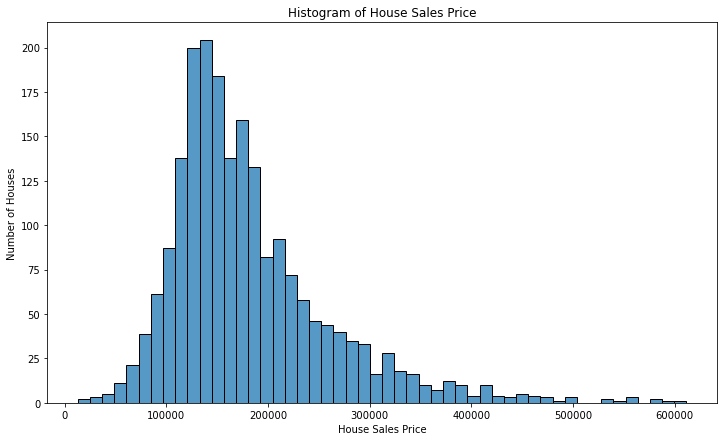

In [626]:
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(df['SalePrice'], bins = 50,kde=False)
plt.xlabel("House Sales Price")
plt.ylabel("Number of Houses")
plt.title("Histogram of House Sales Price");

In [627]:
print("histogram of saleprice is left-skewed and has long right tail")

histogram of saleprice is left-skewed and has long right tail


#### Handle outliers: salesprice
- check outliers of 'SalcePrice' by creating and comparing 'sales price per square feet'

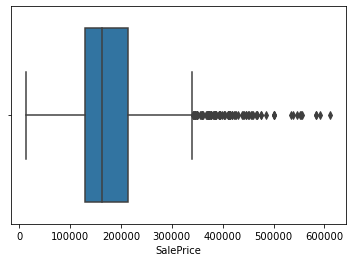

In [628]:
sns.boxplot(df["SalePrice"]);

In [629]:
print("from above boxplot, we can detect possible outliers at high values ")

from above boxplot, we can detect possible outliers at high values 


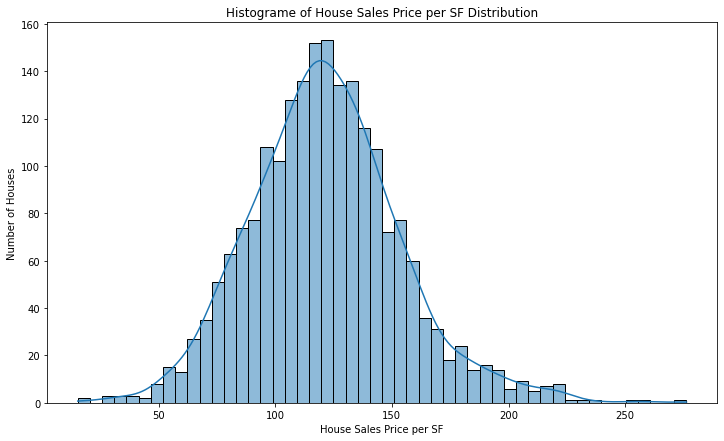

In [630]:
#price per sf
df['SalePricePerSF'] = df.loc[:,'SalePrice']/df.loc[:,'Gr Liv Area']
target=df['SalePricePerSF']
#plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,7))
sns.histplot(target, bins = 50,kde=True)
plt.xlabel("House Sales Price per SF")
plt.ylabel("Number of Houses")
plt.title("Histograme of House Sales Price per SF Distribution");

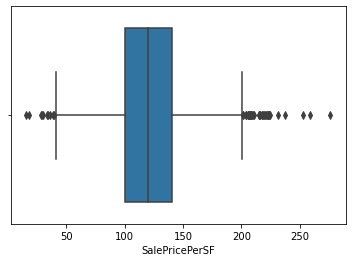

In [631]:
sns.boxplot(df["SalePricePerSF"]);

In [632]:
print('the price per sf ')

the price per sf 


In [633]:
#print out the rows with extremely low price per sf
df[df["SalePricePerSF"]<50].sort_values(by='SalePricePerSF')

,Id,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SalePricePerSF
1628,182,902207130,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0.00,TA,Fa,BrkTil,Fa,Fa,No,Unf,0.00,Unf,0.00,678.00,678.00,GasA,TA,N,SBrkr,832,0,0,832,0.00,0.00,1,0,2,1,TA,5,Typ,1,Detchd,"1,928.00",Unf,2.00,780.00,Fa,Fa,N,0,0,0,0,0,0,0,6,2010,WD,12789,15.37
183,1554,910251050,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.00,Fa,Po,Slab,NA,NA,NA,NA,0.00,NA,0.00,0.00,0.00,Wall,Po,N,FuseA,733,0,0,733,0.00,0.00,1,0,2,1,Fa,4,Sal,0,Attchd,"1,952.00",Unf,2.00,487.00,Fa,Po,N,0,0,0,0,0,0,0,2,2008,WD,13100,17.87
960,1499,908154235,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,"5,644.00",Unf,0.00,466.00,"6,110.00",GasA,Ex,Y,SBrkr,4692,950,0,5642,2.00,0.00,2,1,3,1,Ex,12,Typ,3,Attchd,"2,008.00",Fin,2.00,"1,418.00",TA,TA,Y,214,292,0,0,0,480,0,1,2008,New,160000,28.36
162,754,903430070,90,RM,3000,Pave,Reg,Bnk,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,2Story,5,1,1922,1950,Hip,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,BrkTil,TA,Fa,No,Unf,0.00,Unf,0.00,"1,040.00","1,040.00",GasA,TA,N,SBrkr,1088,1040,0,2128,0.00,0.00,2,0,4,2,TA,11,Sev,0,NA,0.00,NA,0.00,0.00,NA,NA,Y,0,56,0,0,0,0,0,9,2009,WD,62500,29.37
408,1556,911102170,70,C (all),8500,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.00,TA,Fa,BrkTil,TA,TA,No,Unf,0.00,Unf,0.00,649.00,649.00,GasA,TA,N,SBrkr,649,668,0,1317,0.00,0.00,1,0,3,1,TA,6,Typ,0,Detchd,"1,920.00",Unf,1.00,250.00,TA,Fa,N,0,54,172,0,0,0,0,7,2008,WD,40000,30.37
1301,2044,903484080,50,RM,10320,Pave,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00,Fa,Fa,CBlock,TA,Fa,No,Unf,0.00,Unf,0.00,771.00,771.00,GasA,Fa,Y,SBrkr,866,504,114,1484,0.00,0.00,2,0,3,1,TA,6,Sal,0,Detchd,"1,910.00",Unf,1.00,264.00,TA,Fa,N,14,211,0,0,84,0,0,9,2007,COD,50000,33.69
562,187,902401060,190,RM,9045,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,5,3,1910,1950,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,Fa,BrkTil,TA,TA,Mn,Unf,0.00,Unf,0.00,840.00,840.00,Grav,Fa,N,FuseF,1128,1128,0,2256,0.00,0.00,2,0,4,2,Fa,12,Typ,0,NA,0.00,NA,0.00,0.00,NA,NA,N,0,18,18,0,0,0,0,6,2010,WD,76500,33.91
1885,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,"1,224.00",Ex,TA,PConc,Ex,TA,Gd,GLQ,"4,010.00",Unf,0.00,"1,085.00","5,095.00",GasA,Ex,Y,SBrkr,5095,0,0,5095,1.00,1.00,2,1,2,1,Ex,15,Typ,2,Attchd,"2,008.00",Fin,3.00,"1,154.00",TA,TA,Y,546,484,0,0,0,0,17000,10,2007,New,183850,36.08
893,1994,902302150,190,RM,13600,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,5,5,1900,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.00,TA,TA,BrkTil,TA,TA,No,Unf,0.00,Unf,0.00,662.00,662.00,GasA,TA,N,SBrkr,1422,915,0,2337,0.00,0.00,2,0,5,2,TA,10,Min2,0,Detchd,"1,945.00",Unf,2.00,560.00,TA,TA,Y,0,57,0,0,0,0,0,9,2007,WD,90000,38.51
1564,7

**outliers rows:**
- first two rows (index=1628,183) have sale price per sf less than 20, which is too far lower than the rest 
- rows (index=960,1885) are new house but with sale price per sf less than 30, too far lower than the rest



In [634]:
#print out rows with extremely high price per sf
df[df["SalePricePerSF"]>230].sort_values(by='SalePrice',ascending=False)

,Id,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,SalePricePerSF
1671,45,528150070,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,"2,188.00",Unf,0.00,142.00,"2,330.00",GasA,Ex,Y,SBrkr,2364,0,0,2364,1.00,0.00,2,1,2,1,Ex,11,Typ,2,Attchd,"2,009.00",Fin,3.00,820.00,TA,TA,Y,0,67,0,0,0,0,0,3,2010,New,611657,258.74
1964,1638,527216080,20,RL,51974,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,PosN,Norm,1Fam,1Story,9,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,BrkFace,710.00,Ex,TA,PConc,Ex,TA,Av,GLQ,"1,101.00",Unf,0.00,"1,559.00","2,660.00",GasA,Ex,Y,SBrkr,2338,0,0,2338,1.00,0.00,2,1,4,1,Gd,8,Typ,2,Attchd,"2,005.00",Fin,3.00,"1,110.00",Gd,TA,Y,0,135,0,0,322,0,0,6,2007,New,591587,253.03
1164,424,528106020,20,RL,15431,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,"1,767.00",ALQ,539.00,788.00,"3,094.00",GasA,Ex,Y,SBrkr,2402,0,0,2402,1.00,0.00,2,0,2,1,Ex,10,Typ,2,Attchd,"2,008.00",Fin,3.00,672.00,TA,TA,Y,0,72,0,0,170,0,0,4,2009,WD,555000,231.06
1758,1560,911370410,120,RM,5587,Pave,IR1,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,TwnhsE,1Story,8,5,2008,2008,Hip,CompShg,CemntBd,CmentBd,Stone,186.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,"1,480.00",Unf,0.00,120.00,"1,600.00",GasA,Ex,Y,SBrkr,1652,0,0,1652,1.00,1.00,2,0,2,1,Gd,5,Typ,1,Attchd,"2,008.00",Fin,2.00,482.00,TA,TA,Y,162,53,0,153,0,0,0,11,2008,New,392500,237.59
1136,1641,527252070,20,RL,8089,Pave,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.00,Gd,TA,PConc,Gd,TA,Av,GLQ,945.00,Unf,0.00,474.00,"1,419.00",GasA,Ex,Y,SBrkr,1419,0,0,1419,1.00,0.00,2,0,2,1,Gd,7,Typ,1,Attchd,"2,007.00",RFn,2.00,567.00,TA,TA,Y,140,0,0,0,0,0,0,10,2007,New,392000,276.25


**Observations:**
- All those house have huge Lot Area,finished basement area and living area. We cannot judge if they are abnormal, we will keep them first 


In [635]:
#delete abnormal rows
outliers_index=[1628,183,960,1885]
#delete the outliers
print(df.shape)
df=df.drop(index=outliers_index)
print(df.shape)

(2051, 76)
(2047, 76)


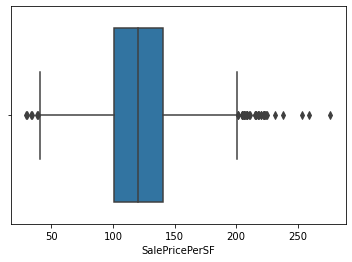

In [636]:
sns.boxplot(df["SalePricePerSF"]);

### EDA: features_numeric

**sort features_numeric by absolute skewness ascendingly for easier EDA**

In [637]:
features_numeric=sorted_by_abs_skew(df, features_numeric)

            feature  skewness  abs_skewness
14        Full Bath      0.11          0.11
31          Yr Sold      0.15          0.15
22      Garage Area      0.16          0.16
30          Mo Sold      0.21          0.21
21      Garage Cars     -0.23          0.23
16    Bedroom AbvGr      0.37          0.37
7     Total Bsmt SF      0.43          0.43
4    Year Remod/Add     -0.45          0.45
3        Year Built     -0.61          0.61
12   Bsmt Full Bath      0.63          0.63
19       Fireplaces      0.71          0.71
15        Half Bath      0.74          0.74
18    TotRms AbvGrd      0.78          0.78
2      BsmtFin SF 1      0.81          0.81
9        2nd Flr SF      0.87          0.87
6       Bsmt Unf SF      0.91          0.91
11      Gr Liv Area      0.93          0.93
8        1st Flr SF      0.96          0.96
23     Wood Deck SF      2.02          2.02
24    Open Porch SF      2.24          2.24
1      Mas Vnr Area      2.57          2.57
25   Enclosed Porch      2.86   

**plot:**
- histographs of numeric features
- pairplot of numeric features and "SalePrice"

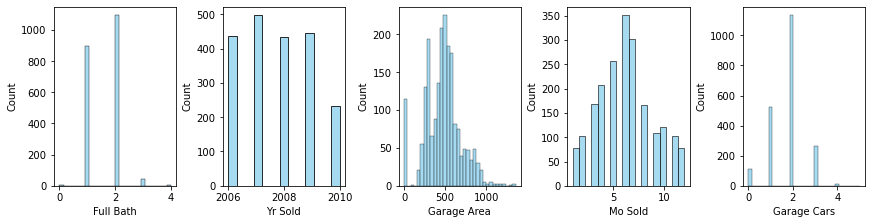

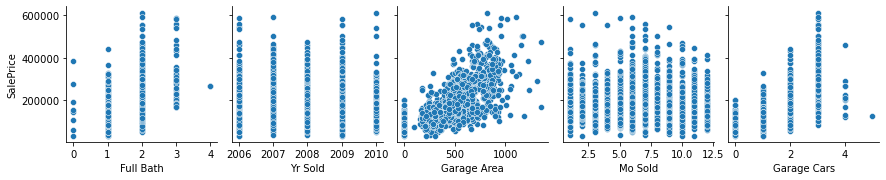

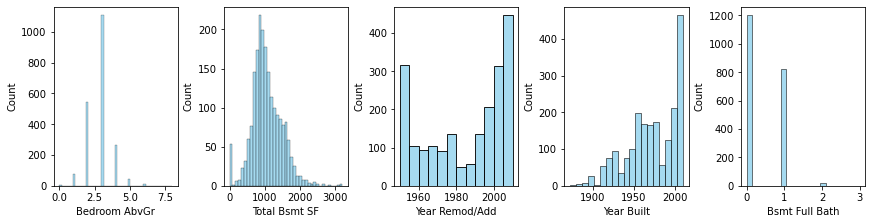

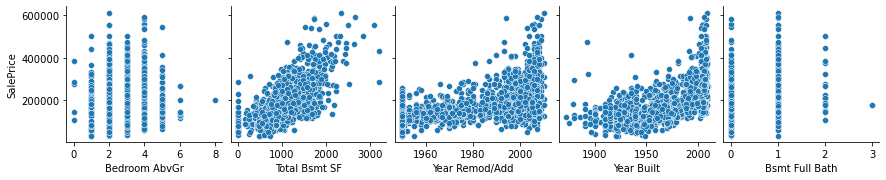

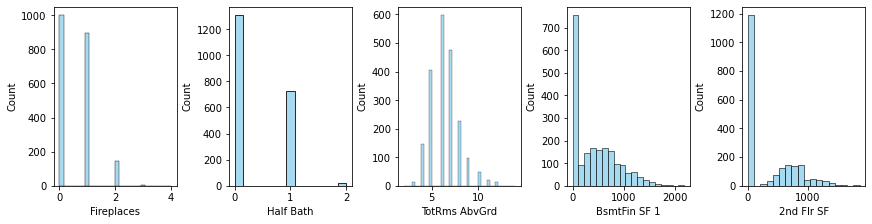

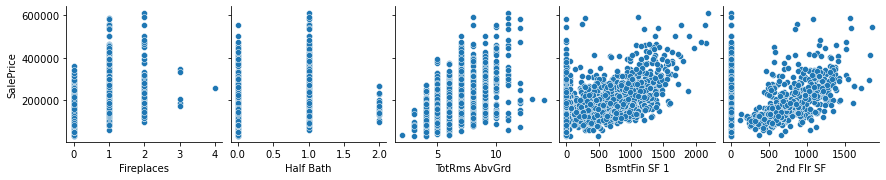

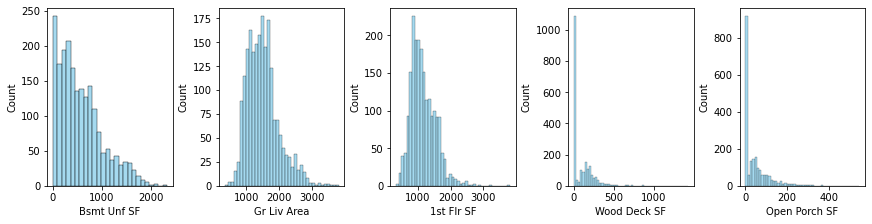

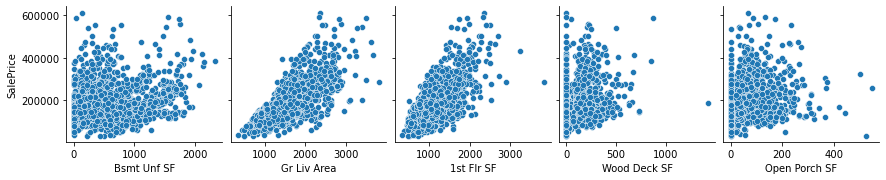

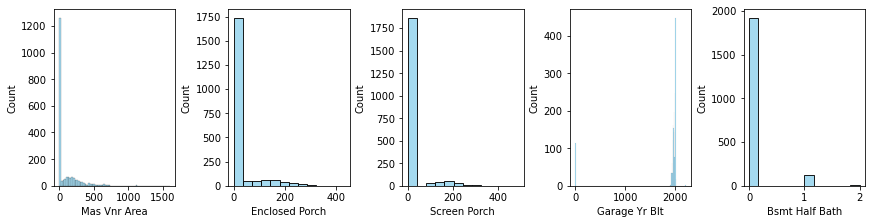

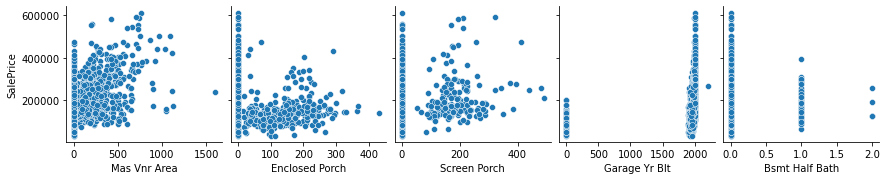

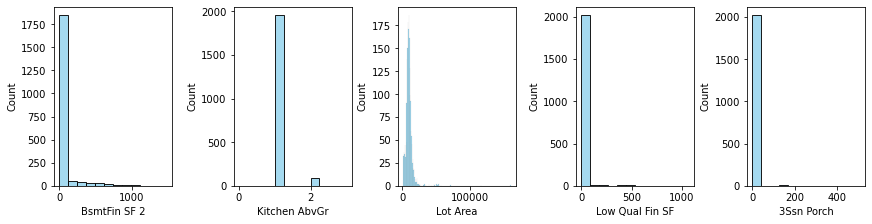

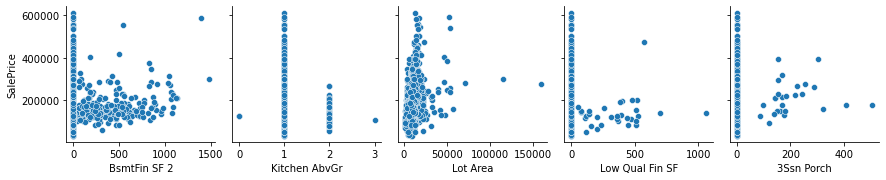

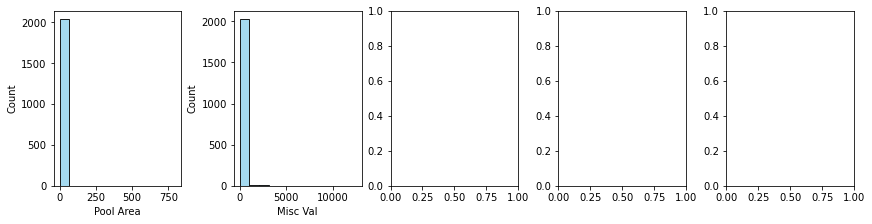

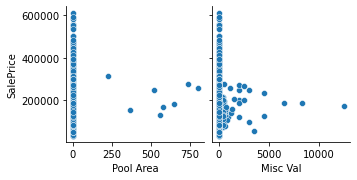

In [638]:
#plot_features(df,x_columns, y_column, columns_in_a_row = 5, feature_type='numeric')
plot_features(df, features_numeric, target_variable,columns_in_a_row = 5, feature_type='numeric')

**observations**
- some features like 'Pool Area' and 'Misc Val' are highly skew, and imbalance
- outliers are detected for most features
- many features about area like 'Gr Liv Area' and 'Total Bsmt SF' seems postive correlated with "SalePrice"
- 'Full Bath', 'Garage Cars', 'Fireplaces' seems positive correlated with "SalePrice"

**checking outliers of features_numeric**

In [639]:
outliers_index = get_indexs_of_outliers_IQR(df, features_numeric, 2.5, direction="upper")
print(f"there are {len(outliers_index)} outliers found in features_numeric")

feature name: Full Bath
Percentiles: 25th=1.000, 75th=2.000, IQR=1.000
index of outliers: set()
feature name: Yr Sold
Percentiles: 25th=2007.000, 75th=2009.000, IQR=2.000
index of outliers: set()
feature name: Garage Area
Percentiles: 25th=319.000, 75th=576.000, IQR=257.000
index of outliers: {1158, 682, 1293, 337, 1557}
feature name: Mo Sold
Percentiles: 25th=4.000, 75th=8.000, IQR=4.000
index of outliers: set()
feature name: Garage Cars
Percentiles: 25th=1.000, 75th=2.000, IQR=1.000
index of outliers: {925}
feature name: Bedroom AbvGr
Percentiles: 25th=2.000, 75th=3.000, IQR=1.000
index of outliers: {1889, 194, 1605, 1256, 1451, 530, 822, 534, 984, 1366, 858, 1789, 1566}
feature name: Total Bsmt SF
Percentiles: 25th=793.000, 75th=1317.500, IQR=524.500
index of outliers: {328, 1227, 1164, 1964, 1147, 1117}
feature name: Year Remod/Add
Percentiles: 25th=1964.500, 75th=2004.000, IQR=39.500
index of outliers: set()
feature name: Year Built
Percentiles: 25th=1954.000, 75th=2001.000, IQR=4

**delete outliers of features_numeric**

In [640]:
#delete the outliers
print(df.shape)
df=df.drop(index=outliers_index)
print(df.shape)
print('deleted 172 outliers')

(2047, 76)
(1875, 76)
deleted 172 outliers


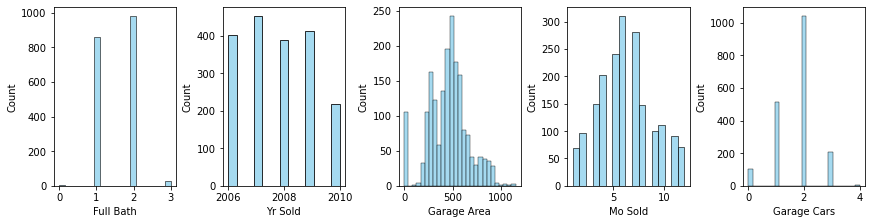

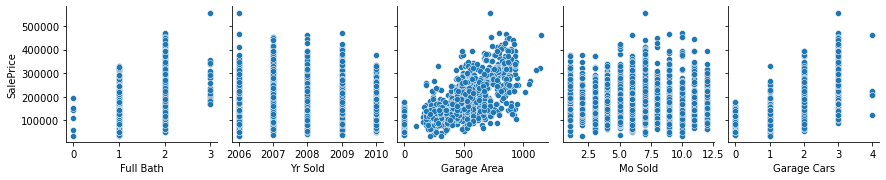

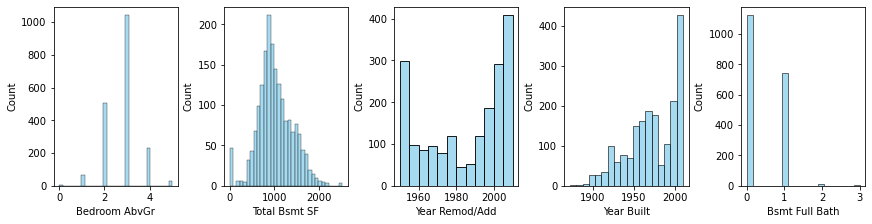

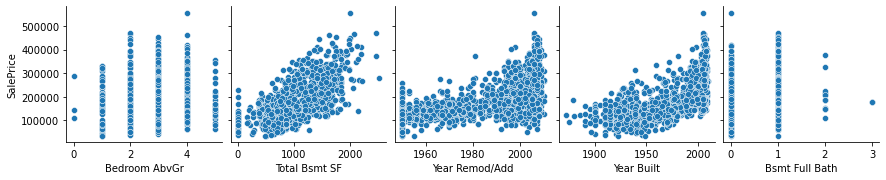

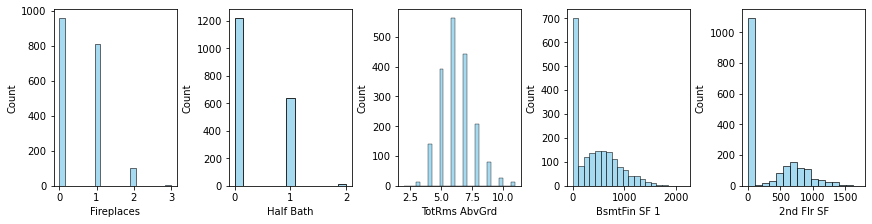

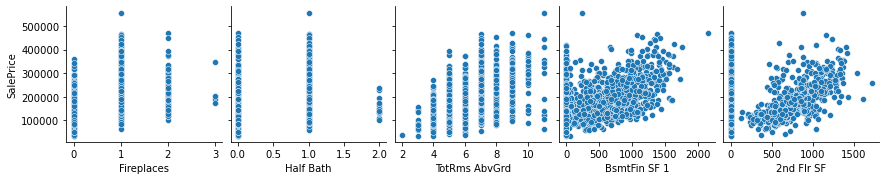

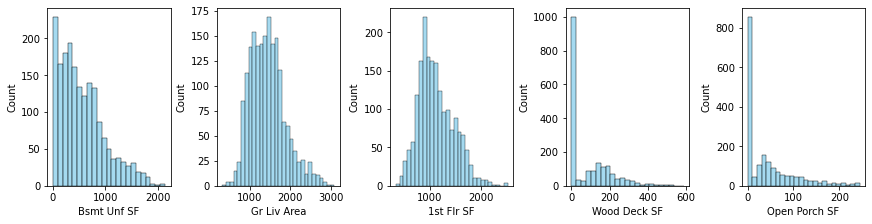

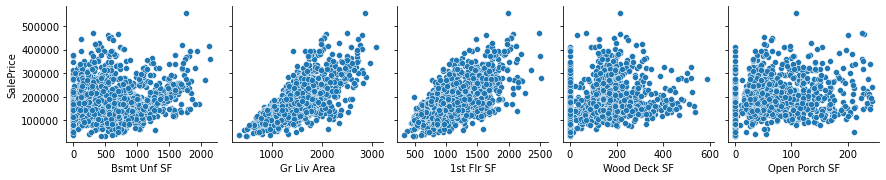

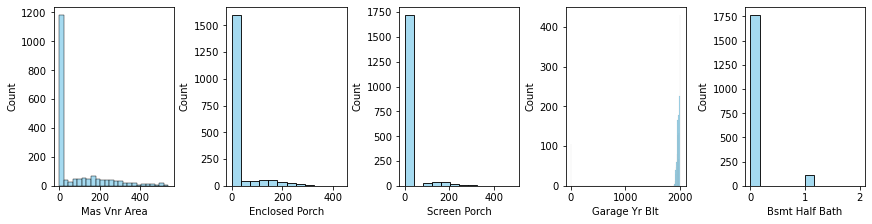

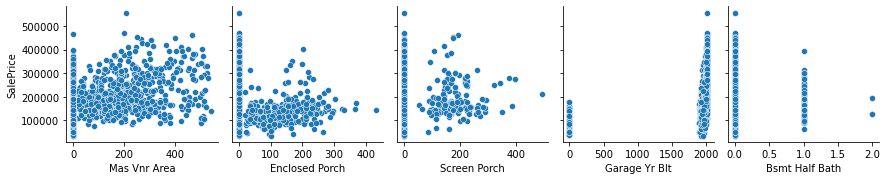

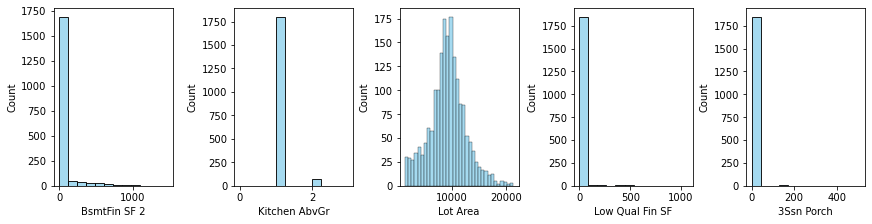

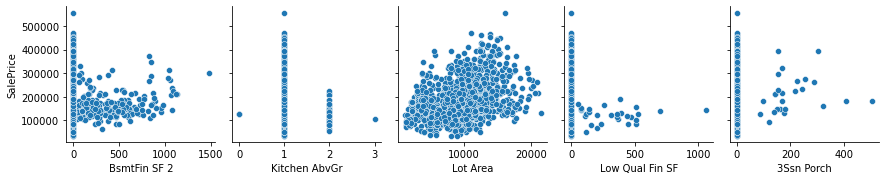

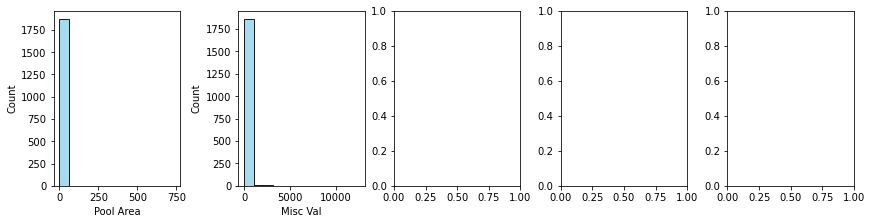

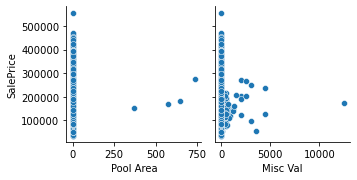

In [641]:
#plot_features(df,x_columns, y_column, columns_in_a_row = 5, feature_type='numeric')
plot_features(df, features_numeric, target_variable,columns_in_a_row = 5, feature_type='numeric')

**obvervations after deleting outliers:**
- there are still some outliers very easy to spot, but most such outliers belong to highly-imbalanced features and since we have deleted 172 outliers. We will leave them first


## EDA and target-encoding Features_ordinal

**plot**
- histographs of numeric features
- pairplot of numeric features and "SalePrice"

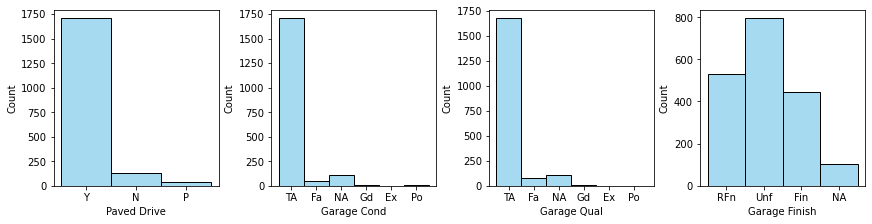

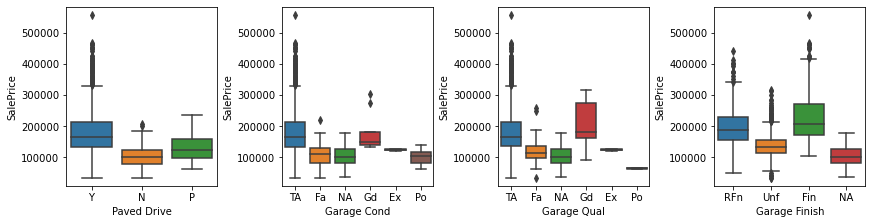

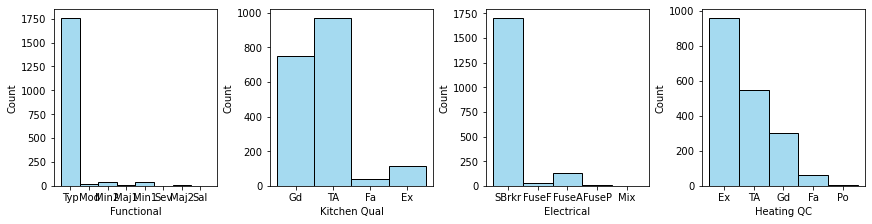

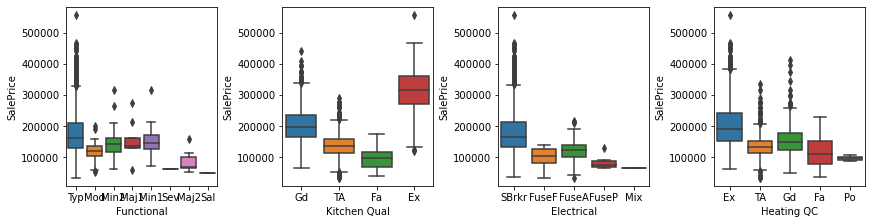

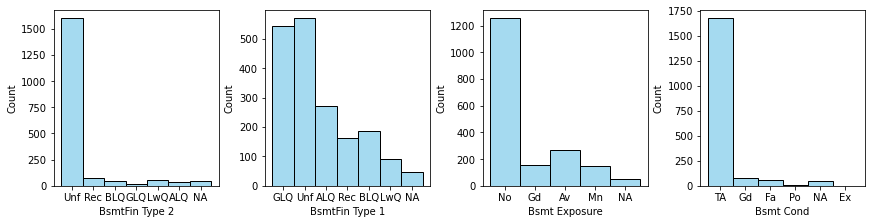

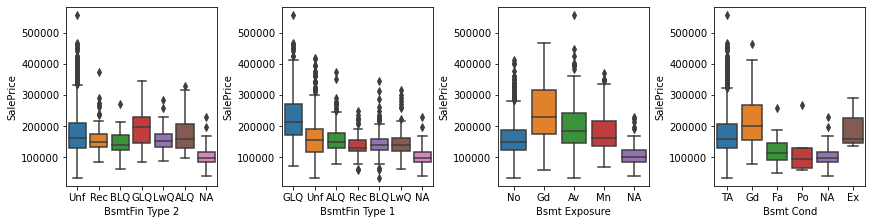

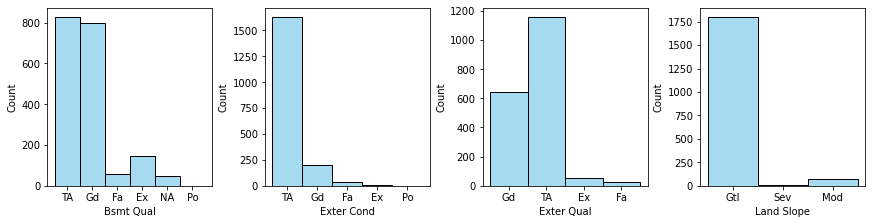

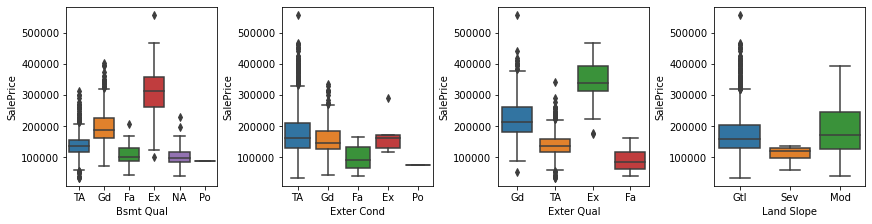

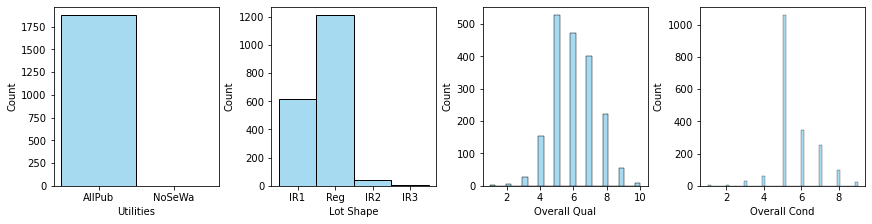

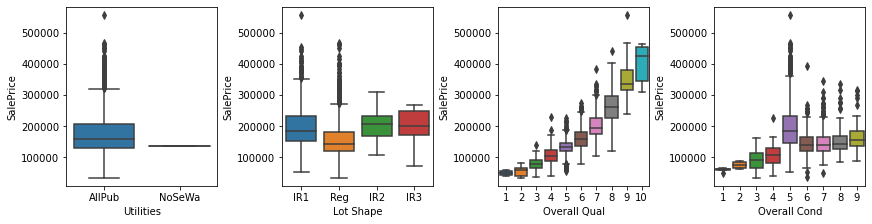

In [642]:
plot_features(df, features_ordinal, target_variable,columns_in_a_row = 4, feature_type='ordinal')

**observations**

- most features are imbalanced
- most features seem not corration with 'SalePrice'
- even though the features are ordinal, the values like 'Ex' and 'Gd' cannot provide meaningful for our machine learning models. 
- **we will target-encode the ordinal features--- replace ordinal value with median of the target variable "SalePrice" in that category--- we think the median 'SalePrice' in the category can numerically differentiate this category from the others**

In [643]:
 #get the target-encoding mapping
ordinal_cols_mapping_target_encoding=get_mapping_target_median_encoding(df, features_ordinal,target_variable)


{'Paved Drive': {'N': 101000.0, 'P': 124450.0, 'Y': 165000.0}, 'Garage Cond': {'Ex': 124000.0, 'Fa': 110000.0, 'Gd': 148000.0, 'NA': 102000.0, 'Po': 106000.0, 'TA': 165150.0}, 'Garage Qual': {'Ex': 124000.0, 'Fa': 113000.0, 'Gd': 180000.0, 'NA': 102000.0, 'Po': 65000.0, 'TA': 165750.0}, 'Garage Finish': {'Fin': 206300.0, 'NA': 102000.0, 'RFn': 188250.0, 'Unf': 134500.0}, 'Functional': {'Maj1': 135750.0, 'Maj2': 68104.0, 'Min1': 145250.0, 'Min2': 142900.0, 'Mod': 122000.0, 'Sal': 50000.0, 'Sev': 62500.0, 'Typ': 160750.0}, 'Kitchen Qual': {'Ex': 317250.0, 'Fa': 97275.0, 'Gd': 196000.0, 'TA': 135000.0}, 'Electrical': {'FuseA': 122250.0, 'FuseF': 105000.0, 'FuseP': 75000.0, 'Mix': 67000.0, 'SBrkr': 165000.0}, 'Heating QC': {'Ex': 191000.0, 'Fa': 111000.0, 'Gd': 149625.0, 'Po': 97000.0, 'TA': 133600.0}, 'BsmtFin Type 2': {'ALQ': 160000.0, 'BLQ': 138750.0, 'GLQ': 198625.0, 'LwQ': 154000.0, 'NA': 98000.0, 'Rec': 150000.0, 'Unf': 162500.0}, 'BsmtFin Type 1': {'ALQ': 150000.0, 'BLQ': 138500.0, 

In [644]:
#replace categorical value with median of the target variable "SalePrice" in that category
df = df.replace(ordinal_cols_mapping_target_encoding)

In [645]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['ordinal_cols_mapping_target_encoding']=ordinal_cols_mapping_target_encoding


In [646]:
#checking if target encoding succeed or not by checking if the ordinal features Dtype changed from 'object' to 'float64' 
df[features_ordinal].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 2050
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Paved Drive     1875 non-null   float64
 1   Garage Cond     1875 non-null   float64
 2   Garage Qual     1875 non-null   float64
 3   Garage Finish   1875 non-null   float64
 4   Functional      1875 non-null   float64
 5   Kitchen Qual    1875 non-null   float64
 6   Electrical      1875 non-null   float64
 7   Heating QC      1875 non-null   float64
 8   BsmtFin Type 2  1875 non-null   float64
 9   BsmtFin Type 1  1875 non-null   float64
 10  Bsmt Exposure   1875 non-null   float64
 11  Bsmt Cond       1875 non-null   float64
 12  Bsmt Qual       1875 non-null   float64
 13  Exter Cond      1875 non-null   float64
 14  Exter Qual      1875 non-null   float64
 15  Land Slope      1875 non-null   float64
 16  Utilities       1875 non-null   float64
 17  Lot Shape       1875 non-null   f

In [647]:
print("all ordinal features have been target-encoded")

all ordinal features have been target-encoded


**sort features_ordinal by absolute skewness ascendingly for easier EDA**

In [648]:
features_ordinal=sorted_by_abs_skew(df, features_ordinal)

           feature  skewness  abs_skewness
3    Garage Finish     -0.14          0.14
7       Heating QC     -0.27          0.27
15      Land Slope     -0.34          0.34
9   BsmtFin Type 1      0.51          0.51
17       Lot Shape      0.70          0.70
19    Overall Cond     -0.86          0.86
10   Bsmt Exposure      1.30          1.30
18    Overall Qual      1.30          1.30
11       Bsmt Cond     -1.40          1.40
14      Exter Qual      1.42          1.42
12       Bsmt Qual      1.51          1.51
5     Kitchen Qual      1.53          1.53
2      Garage Qual     -2.75          2.75
1      Garage Cond     -2.99          2.99
0      Paved Drive     -3.01          3.01
6       Electrical     -3.27          3.27
8   BsmtFin Type 2     -3.64          3.64
13      Exter Cond     -5.03          5.03
4       Functional     -7.78          7.78
16       Utilities    -43.30         43.30

features sorted: 
 ['Garage Finish', 'Heating QC', 'Land Slope', 'BsmtFin Type 1', 'Lot Shape', 

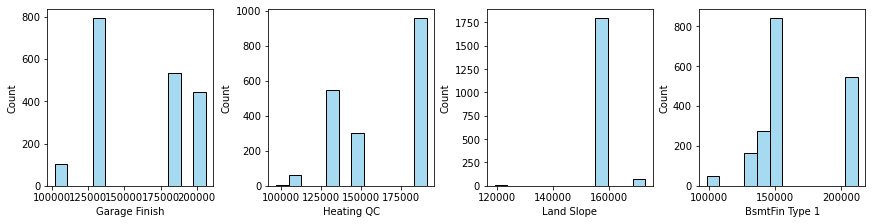

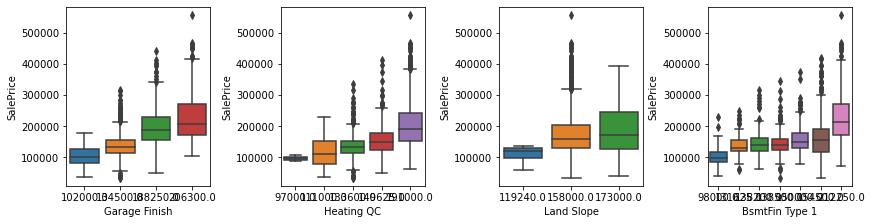

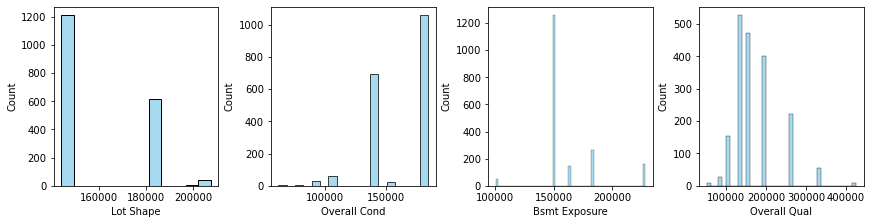

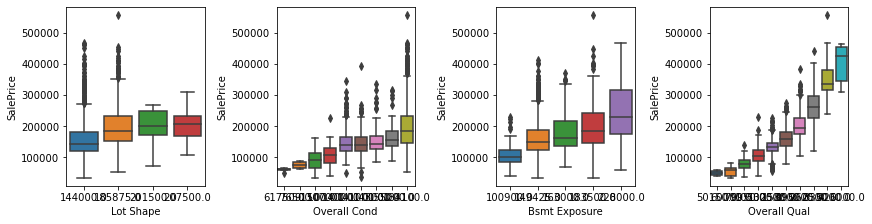

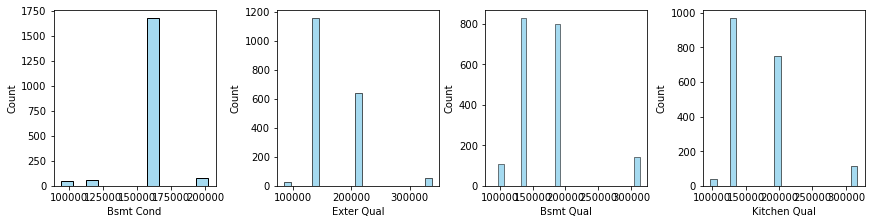

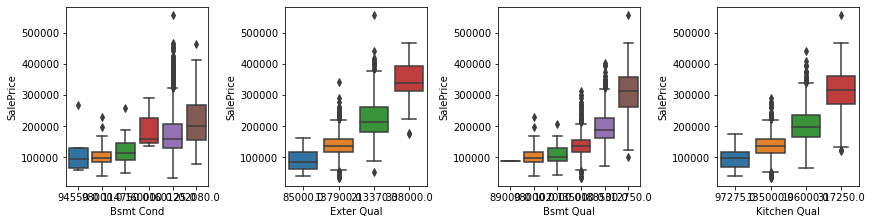

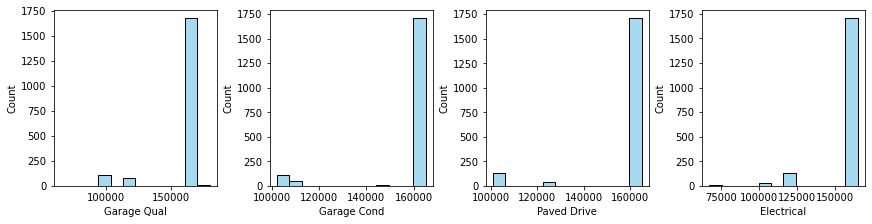

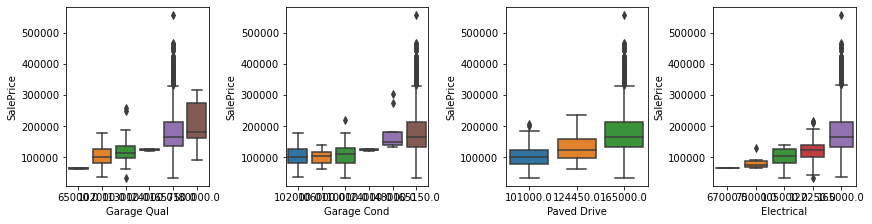

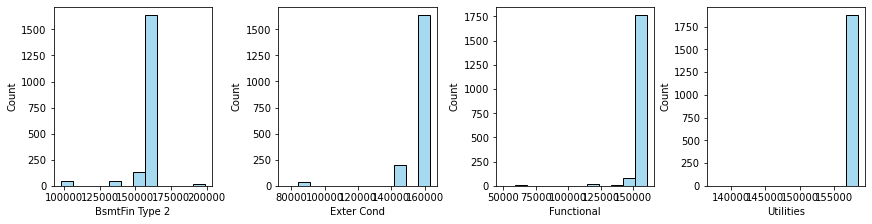

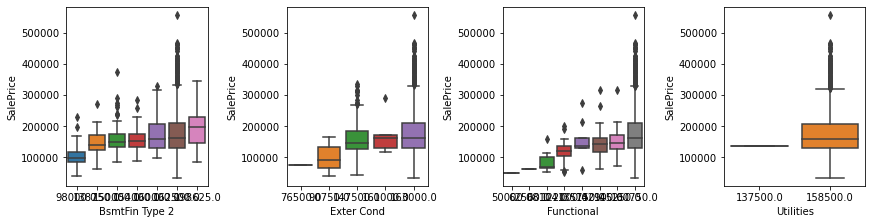

In [649]:
plot_features(df, features_ordinal, target_variable,columns_in_a_row = 4, feature_type='ordinal')

**observations**
- Many features like 'Functional' and 'Utilities' are highly skew, and imbalance
- Big range of "SalePrice" in most categories of every features 
- Many features such as 'Garage Finish' and 'Overall Qual' seem postive correlated with "SalePrice"


## EDA and target-encoding Features_categorical

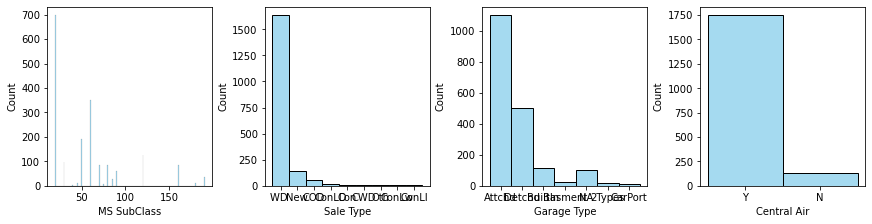

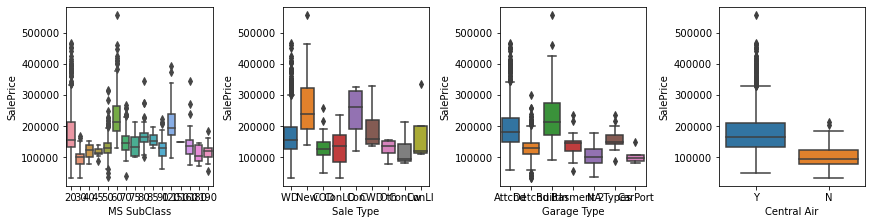

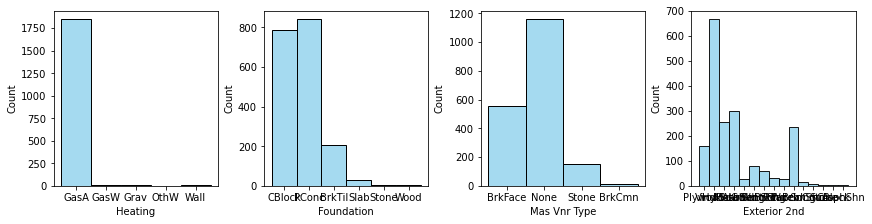

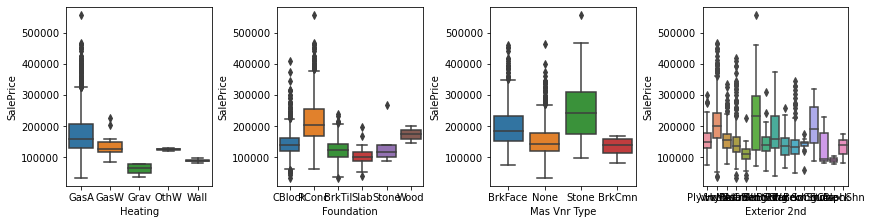

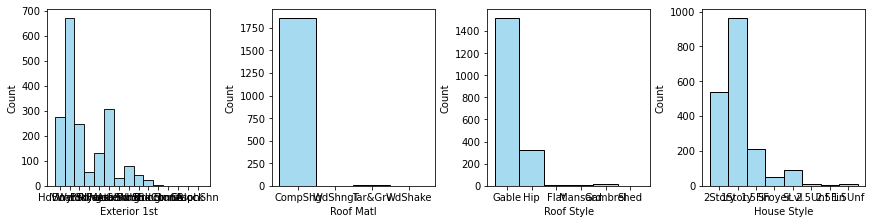

In [ ]:
plot_features(df, features_categorical, target_variable,columns_in_a_row = 4, feature_type='categorical')

**observations**
- most features are imbalanced
- most features seem not corration with 'SalePrice'
- even though the features are categorical, the values like 'Pave' and 'Grvl' cannot provide meaningful data for machine learning models. 
- **we will target-encode the categorical features--- replace categorical value with median of the target variable "SalePrice" in that category--- we think the median 'SalePrice' in the category can numerically differentiate this category from the others**

In [ ]:
#get the mapping of target-encoding
categorical_cols_mapping_target_encoding=get_mapping_target_median_encoding(df, features_categorical,target_variable)

In [ ]:
#replace categorical value with median of the target variable "SalePrice" in that category
df = df.replace(categorical_cols_mapping_target_encoding)

df[features_categorical].info()

In [ ]:
print("All categorical features have been target-encoded")

In [ ]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['categorical_cols_mapping_target_encoding']=categorical_cols_mapping_target_encoding


**sort features_categorical by absolute skewness ascendingly for easier EDA**

In [ ]:
features_categorical=sorted_by_abs_skew(df, features_categorical)

In [ ]:
plot_features(df, features_categorical, target_variable,columns_in_a_row = 4, feature_type='categorical')

**observations**
- Many features like 'Street' and 'Roof Matl' are highly skew, and imbalance
- Big range of "SalePrice" in most categories of every features 
- Many features such as 'MS Zoning' and 'Foundation' seems postive correlated with "SalePrice"


# Feature Selection
**Basic Steps**
- Select features with an high absolute correlation (>0.4) with "SalePrice"
- And then among those features, drop the features if they have high correlation (>0.6) with the others   

### selecting numeric features

In [ ]:
features_numeric_selected = select_features_by_corr(df, features_numeric, target_variable, corr_threhold)

**checking multicollinearity of features_numeric_selected**

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_numeric_selected].corr(), annot=True)

**drop features with corr more than 0.6 with other features**
- we will keep those features with high corr with "SalePrice" when there is a multicollinearity conflict
- 'Gr Liv Area' is highly correlated with 'TotRms AbvGrd','Garage Area', we will drop the later two
- 'Total Bsmt SF' is highly correlated with '1st Flr SF'
- 'Year Built' is highly correlated with 'Year Remod/Add'

In [ ]:
#drop the features casusing multicollinearity
features_numeric_selected = list(set(features_numeric_selected ) 
                                -
                                set(['TotRms AbvGrd','Full Bath','1st Flr SF','Garage Area','Year Remod/Add']))

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_numeric_selected].corr(), annot=True)

### selecting features_ordinal

In [ ]:
features_ordinal_selected = select_features_by_corr(df, features_ordinal, target_variable, corr_threhold)

**checking multicollinearity of features_ordinal_selected**

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_ordinal_selected].corr(), annot=True)

**drop features with corr more than 0.6 with other features**
- we will keep those features with high corr with "SalePrice" when there is a multicollinearity conflict
- 'Overall Qual' is highly correlated with ''Exter Qual', 'Bsmt Qual', 'Kitchen Qual', we will drop the later three


In [ ]:
features_ordinal_selected = list(set(features_ordinal_selected ) 
                                -
                                set(['Exter Qual', 'Bsmt Qual', 'Kitchen Qual']))

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df[features_ordinal_selected].corr(), annot=True)

### selecting features_categorical

In [ ]:
features_categorical_selected = select_features_by_corr(df, features_categorical, target_variable, corr_threhold)

**checking multicollinearity of features_ordinal_selected**

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df[features_categorical_selected].corr(), annot=True)

**check and drop features with corr more than 0.6 from the heatmap**
- we will keep those features with high corr with "SalePrice" when there is a multicollinearity conflict
- 'Exterior 1st' is highly correlated with 'Exterior 2nd'', we will drop the later 


In [ ]:
features_categorical_selected = list(set(features_categorical_selected ) 
                                -
                                set(['Exterior 2nd']))

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df[features_categorical_selected].corr(), annot=True)

## Preparing features_final

In [ ]:
#combine features_numeric_selected, features_ordinal_selected, features_categorical_selected
features_selected = features_numeric_selected + features_ordinal_selected + features_categorical_selected

print(features_selected)
print(len(features_selected))

**checking multicollinearity of features_selected**

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_selected].corr(), annot=True)

**Based on same logic, we will drop the features with lower corr with "SalePrice" when they have multicollinearity comflict**

In [ ]:
features_final = list(set(features_selected ) 
                      -
                      set(['Year Built','Mas Vnr Type','Garage Type']))
print(features_final)
print(len(features_final))

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(df[features_final].corr(), annot=True)

**We have checked and all correlations are less than 0.6**


In [ ]:
print(f'features_final has {len(features_final)} features: \n', features_final )

In [ ]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
#pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb')
pickle_dict['features_final']=features_final

# Modeling

## 1. Metrics
We will use two metrics for performance measure
- MAE: Mean Absolute Error to measure accuracy of our models. The smaller MAE is, the better.
- perc_diff:  % of difference of MAE_train and MAE_test to measure generality of our models. For our production model, the perc_diff must be less than 2% 

## 2. Do Train-Test Split

In [ ]:
X = df[features_final]
y = df[target_variable]

# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=133)

print(X_train.shape)
print(X_test.shape)


## 3. Baseline Model - mean of y_train 

In [ ]:
#print(f"Mean of 'SalePrice' in y_train is : {y_train.mean():,.2f}")
y_train_pred = [y_train.mean() for i in y_train]
#print(y_train_pred)
y_test_pred = [y_train.mean() for i in y_test]
MAE_baseline, perc_diff_baseline = model_evaluation(y_train,y_train_pred, y_test,y_test_pred)

In [ ]:
print(f"Average SalePrice is ${int(y_train.mean()):,}")
print(f"MAE of baseline model is {int(MAE_baseline):,}, around {int(MAE_baseline/y_train.mean()*100)}% of average saleprice")
print(f"diff% is {perc_diff_baseline:.2f}%, more than 2%, this model cannot pass our metrics")

In [ ]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred);

In [ ]:
print('The better the model is, the more similar the distribution of y_test and y_test_pred are')
print('The better the model is, the closer pairplots of y_test and y_test_pred are to the redline')


## 4.  linear regression

In [ ]:
model = LinearRegression()
param = {}

gs_lr, y_train_pred, y_test_pred = run_model(X_train, X_test, y_train, y_test, model, param)
df_coefs_lr = get_coefs(gs_lr,X,y)
df_coefs_lr[['feature', 'coef']].head(100)

In [ ]:
print(f"Average SalePrice is ${int(y_train.mean()):,}")
print(f"MAE of linear regression model is 17,516, around {int(17516/y_train.mean()*100)}% of average saleprice")
print(f"diff% is -1.43%, less than 2%, this model pass our metric")

In [ ]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred);

In [ ]:
print('The better the model is, the more similar the distribution of y_test and y_test_pred are')
print('The better the model is, the closer pairplots of y_test and y_test_pred are to the redline')


## 5. Ridge Regression Model 

In [ ]:
model = Ridge()
alphas = np.logspace(-1,3, 100)
param = {'classifier__alpha': alphas}

gs_ridge, y_train_pred, y_test_pred= run_model(X_train, X_test, y_train, y_test, model, param)

df_coefs_ridge = get_coefs(gs_ridge,X,y)
df_coefs_ridge[['feature', 'coef']].head(100)

In [ ]:
print(f"Average SalePrice is ${int(y_train.mean()):,}")
print(f"MAE of linear regression model is 17,429, around {int(17429/y_train.mean()*100)}% of average saleprice")
print(f"diff% is 0.30%, less than 2%, this model pass our metric")

In [ ]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred);

In [ ]:
print('The better the model is, the more similar the distribution of y_test and y_test_pred are')
print('The better the model is, the closer pairplots of y_test and y_test_pred are to the redline')


## 6. Lasso Regression Model

In [ ]:
X = df[features_final]
y = df[target_variable]

# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=133)

model = Lasso()
alphas = np.logspace(-1,3, 100)
param = {'classifier__alpha': alphas}

gs_lasso, y_train_pred, y_test_pred = run_model(X_train, X_test, y_train, y_test, model, param)

df_coefs_lasso = get_coefs(gs_lasso,X,y)
df_coefs_lasso[['feature', 'coef']].head(100)



In [ ]:
print(f"Average SalePrice is ${int(y_train.mean()):,}")
print(f"MAE of linear regression model is 17,439, around {int(17439/y_train.mean()*100)}% of average saleprice")
print(f"diff% is -0.27%, less than 2%, this model pass our metric")

In [ ]:
#plot the histogram and pairplot of y_test and y_test_pred
plot_y_y_pred(y_test, y_test_pred)

In [ ]:
print('The better the model is, the more similar the histogram of y_test and y_test_pred are')
print('The better the model is, the closer pairplots of y_test and y_test_pred are to the redline')


# Production Model

We will use the model derived by Lasso because of this model has reduced 2 more features while it still has similiar MAE

**Observations**:
- all 3 modals have similiar results, which indicating there is no overfitting issues, but all models may have bias

In [ ]:
#save neccessary object to pickle_dict, which will be pickled at the end for kaggle test data
pickle_dict['production model']=gs_lasso
pickle.dump(pickle_dict, open('../datasets/data.pkl', 'wb'))
print(pickle_dict)

# LINE Assumptions

#### Linearity

In [ ]:
#plot the pairplot of features with "SalePrice"
features_coefs=df_coefs_lasso['feature']
plot_features(df,features_coefs, target_variable, columns_in_a_row = 5, feature_type='numeric',if_show_histo=False)


**Observations:**
- most features are positively correlatd with "SalePrice" but it seems that they are not clearly linaerly correlated with "SalePrice"


### Independence

In [ ]:
#plot the heatmap of correlations of the features
plt.figure(figsize=(20,20))
sns.heatmap(df[features_coefs[:-2]].corr(), annot=True)

In [ ]:
print("No high correlations (>0.6) are found, indicating there are no multicollinearity found")

In [ ]:
#print the vif 
df_coefs_lasso[['feature', 'coef', 'vif']].head(100)

In [ ]:
print("All VIF are less than 5, indicating there are no multicollinearity found")

### Normality of errors

In [ ]:
# Create residuals (aka errors): (y - y_hat)
resids_test = y_test - y_test_pred

In [ ]:
plt.hist(resids_test, bins=50);

In [ ]:
# q-q plot
qqplot(resids_test,line='s')
plt.show();

In [ ]:
print('the histogram and Q-Q plot show that residuals form a roughly normal distribution of residuals with right big tail ')

### Equal variance of errors

In [ ]:
plt.scatter(y_test_pred, resids_test, s=1)
plt.axhline(0, color="orange");

In [ ]:
print('the variance of residuals seems not equal at each point')

In [ ]:
print("Our production model does not meet the LINE assumption")

# Select important features for home improvement and analyze their partial dependence with "SalePrice"

In [ ]:
#print out the coefs of our productin model
df_coefs_lasso[['feature', 'coef']].head(100)

**Selecting important features for home improvement:**
- 'Overall Qual' is an ordinal feature and very subjective, and it doesn't refer to specific part of a house. We do not suggest it as home improvement feature
- 'Gr Liv Area': Above grade (ground) living area square feet. Most of time, it is very difficult to change it without changing the main struturue. We do not  recommend it as home improvement feature
- 'BsmtFin SF 1': basement finished area, third important feature to affect sale price. Very suitable for home improvement
- 'Total Bsmt SF':Total square feet of basement area, same as 'Gr Liv Area', not  recommended for home improvement
- 'Garage Cars': Size of garage in car capacity, same as 'Gr Liv Area', not  recommended for home improvement
- 'Heating QC': Heating quality and condition, ordinal and subjective feature, not  recommended
- 'Fireplaces': Number of fireplaces, easy to install. It is highly  recommended for home improvement
- 'Foundation': Type of foundation. Change of this feature is very costly, not worthy due to its limited contribution to the saleprice
- the remaining features are not considered because of their limited contribution to saleprice


In [ ]:
print('The following features are recommaneded for home improvement:')
print("'BsmtFin SF 1': basement finished area")
print("'Fireplaces': Number of fireplaces")

 #### Analyze partial dependence of  recommended home improvement features with "SalePrice"

In [ ]:
feature = 'BsmtFin SF 1'
plot_partial_dependence(gs_lasso, X_train, feature)

**The partial dependence suggest that for every 1200 sf of finished bastment area, the sale price will increase by around 25,000 dollars, roughly 20.8 dollars per square feet**

In [ ]:
feature = 'Fireplaces'
plot_partial_dependence(gs_lasso, X_train, feature)

**The partial dependence analyse suggest that for every 1 fireplaces, the sale price will increase by around 6,149 dollars**


# Create models for selected neighborhoods
we will do the following:
- check how many records each neighborhood has
- check the average 'Year Built' in each neighborhood
- create models for one old neighborhood and one new neighborhood 
- check and analyse what features are important for old neighborhood and old neighborhood

In [ ]:
neighborhoods = df['Neighborhood'].unique()
print(neighborhoods)

In [ ]:
#create a dictory to store {neigborhood: its records}
X_dict = {}
for neighborhood in neighborhoods:
    #print(neighborhood)
    X=df.loc[df['Neighborhood'].str.contains(neighborhood),features_final]
    print(neighborhood, ': shape:', X.shape)
    X_dict[neighborhood] = X
    

In [ ]:
#checking the average 'Year Built' for each neighborhood
pd_neighbor=pd.DataFrame(df.groupby('Neighborhood').mean()['Year Built'])
pd_neighbor.reset_index(drop=False, inplace=True)
pd_neighbor.sort_values(by='Year Built', inplace=True)
#rs.columns=['Neighborhood','Avg Year Built']
pd_neighbor['Avg Year Built']=pd_neighbor['Year Built'].astype(int)
pd_neighbor[['Neighborhood', 'Avg Year Built']].head(100)

#### Create model for old neighborhood 'OldTown' 

In [ ]:
neighborhood = 'OldTown'
X=X_dict[neighborhood]
y=df.loc[df['Neighborhood'].str.contains(neighborhood),["SalePrice"]]
gs_oldtown = get_best_model_by_neighborhood(neighborhood, X, y) 

**Based on the model for 'OldTown', 'Fireplaces' are  recommended for home improvement**

In [ ]:
feature = 'Fireplaces'
plot_partial_dependence(gs_oldtown, X, feature)

**The partial dependence analyse suggest that for every 1 fireplaces, the sale price will increase by around 5,485 dollars**


#### Create model for old neighborhood 'Somerst' 

In [ ]:
neighborhood = 'Somerst'
X=X_dict[neighborhood]
y=df.loc[df['Neighborhood'].str.contains(neighborhood),["SalePrice"]]
gs_somerst=get_best_model_by_neighborhood(neighborhood, X, y,2654) 

**Based on the model for 'Somerst', 'BsmtFin SF 1', 'Fireplaces' are  recommended for home improvement**

In [ ]:
feature = 'BsmtFin SF 1'
plot_partial_dependence(gs_somerst, X, feature)

**The partial dependence suggest that for every 719 sf of finished bastment area, the sale price will increase by around 22,330 dollars, roughly 31 dollars per square feet**

In [ ]:
feature = 'Fireplaces'
plot_partial_dependence(gs_somerst, X, feature)

**The partial dependence analyse suggest that for every 1 fireplaces, the sale price will increase by around 8,716 dollars**


## Conclusions and Recommendations

- We built several models and found lasso models had the best performance
- Based on the lasso model, we analyzed and found ' BsmtFin SF 1' and 'Fireplaces' as  recommended features for home improvements
- We built models for selected neighborhoods and  recommended some feature for home improvement
- The neighorhood models also suggest that it is better to do home improvement for newer houses or high value houses because it can create more value 

## Limitation and Future Enhancement
- Our 3 multiple regression models have very similar performance, indicating our model might be underfitting, adding more futures may increase model performance
- Our models cannot meet the LINE assumption, other non-regression models should be considered
- Many data are highly imbalance and barely useful. Data collector might redesign what to be collected in the future
- Many neigbhorhoods have insufficient data to build meaningful models. More data is needed